In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import random
from scipy.interpolate import UnivariateSpline  
import pickle
from sklearn.decomposition import PCA
import time
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array
from numpy import hstack

In [5]:
from google.colab import drive #comment out this line if you are using Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
main_path = "/content/drive/My Drive/BIOE PROJECT"
os.chdir(main_path)

In [7]:
class MV_LSTM(torch.nn.Module):
  def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        self.hidden = (hidden_state, cell_state)
  def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        #lstm_out, self.hidden = self.l_lstm(x)
        
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.sigmoid(self.l_linear(x))
  def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 30 # number of hidden states
        self.n_layers = 4 # number of LSTM layers (stacked)
        self.dropout = nn.Dropout(0.1) 

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True
                                 )
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 100)
        self.sigmoid = nn.Sigmoid()
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    
    for i in range(0,len(sequences),100):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if i!=0 and end_ix > len(sequences):
            break
        
        sequences[i:end_ix,0]=np.insert(np.diff(sequences[i:end_ix,0]),0,0)
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix-33], sequences[end_ix-33:end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y) 
    


In [9]:
csv_path = os.path.join(main_path,"covid_19_clean_complete.csv")

In [10]:
df = pd.read_csv(csv_path, skiprows=0)
df.head()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


(49068, 10)

In [13]:
df['Country/Region'].value_counts()

China             6204
Canada            2256
France            2068
United Kingdom    2068
Australia         1504
                  ... 
Holy See           188
Honduras           188
Hungary            188
Iceland            188
Lesotho            188
Name: Country/Region, Length: 187, dtype: int64

In [14]:
is_china =  (df['Country/Region']=='China')

In [61]:
#read testing data
df2 = pd.read_csv('covid_19_clean_complete.csv', skiprows=0)
df2.head()
df2.info()

is_indonesia =  (df2['Country/Region']=='Indonesia')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


In [63]:
df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Active', 'WHO Region'],
      dtype='object')

In [64]:
data=df[df['Country/Region'].isin(['China','Germany','Australia','Brazil','US','Belgium','Spain','Italy','UK','France','Japan','Malaysia','Vietnam','Iran','UEA','Singapore','Thailand','Korea, South','Japan','Iran','Netherlands','Russia','Chile','India','Greece','Mexico','Mongolia','Philippines','New Zealand','South Africa','Botswana','Uruguay','Paraguay','Madagascar','Peru', 'Portugal', 'Denmark','Hungary','Kenya','Ireland','Israel','Norway','Mauritius','Rwanda','Iceland','Kazakhstan','Switzerland','Cyprus','Zimbabwe'])][['Confirmed','Lat','Long','Recovered','Deaths']]

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18236 entries, 8 to 49060
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  18236 non-null  int64  
 1   Lat        18236 non-null  float64
 2   Long       18236 non-null  float64
 3   Recovered  18236 non-null  int64  
 4   Deaths     18236 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 854.8 KB


In [66]:
#testing data filtering
data2=df2[(is_indonesia)][['Confirmed','Lat','Long','Recovered','Deaths']]
date=df2[(is_indonesia)][['Date','Confirmed']]

date.Date = pd.to_datetime(date.Date,format='%Y%m%d', errors='ignore')
date.set_index('Date', inplace=True)

In [67]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 130 to 48937
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  188 non-null    int64  
 1   Lat        188 non-null    float64
 2   Long       188 non-null    float64
 3   Recovered  188 non-null    int64  
 4   Deaths     188 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 8.8 KB


In [68]:
n_features = 5 # this is number of parallel inputs
n_timesteps = 100 # this is number of timesteps

In [69]:
#input splitting
X, Y = split_sequences(data.values, n_timesteps)



print (X.shape,Y.shape)

(182, 67, 5) (182, 33, 5)


In [70]:
#normalization
alld=np.concatenate((X,Y),1)
alld=alld.reshape(alld.shape[0]*alld.shape[1],alld.shape[2])



scaler = MinMaxScaler()
scaler.fit(alld)
X=[scaler.transform(x) for x in X]
y=[scaler.transform(y) for y in Y]

X=np.array(X)
y=np.array(y)[:,:,0]

In [71]:
#training

mv_net = MV_LSTM(n_features,67).cuda()
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-3)

train_episodes = 5000

batch_size = 16

mv_net.train()

for t in range(train_episodes):
    
    for b in range(0,len(X),batch_size):
       
        p = np.random.permutation(len(X))
        
        inpt = X[p][b:b+batch_size,:,:]
        target = y[p][b:b+batch_size,:]    
        
        x_batch = torch.tensor(inpt,dtype=torch.float32).cuda()    
        y_batch = torch.tensor(target,dtype=torch.float32).cuda()
       
        mv_net.init_hidden(x_batch.size(0))
        
        output = mv_net(x_batch) 
        
        
        all_batch=torch.cat((x_batch[:,:,0], y_batch), 1)
        
        
        loss = 1000*criterion(output.view(-1), all_batch.view(-1))  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
    print('step : ' , t , 'loss : ' , loss.item())

step :  0 loss :  1.3156030178070068
step :  1 loss :  1.6854678392410278
step :  2 loss :  2.234259843826294
step :  3 loss :  0.5086964964866638
step :  4 loss :  1.1357094049453735
step :  5 loss :  2.4400548934936523
step :  6 loss :  0.011519082821905613
step :  7 loss :  0.7489659190177917
step :  8 loss :  0.6517323851585388
step :  9 loss :  0.47212737798690796
step :  10 loss :  1.112180233001709
step :  11 loss :  1.7439284324645996
step :  12 loss :  0.05969250202178955
step :  13 loss :  0.48307228088378906
step :  14 loss :  1.3547922372817993
step :  15 loss :  1.978734016418457
step :  16 loss :  0.5416404604911804
step :  17 loss :  0.1721121221780777
step :  18 loss :  0.8078687191009521
step :  19 loss :  0.6695352792739868
step :  20 loss :  0.5642621517181396
step :  21 loss :  1.7051478624343872
step :  22 loss :  2.0812501907348633
step :  23 loss :  1.8967558145523071
step :  24 loss :  0.37580183148384094
step :  25 loss :  0.9418275952339172
step :  26 loss :  

In [97]:
#evaluation
import matplotlib.pyplot as plt
data2x=data2
truth = data2

data2x.values[0:len(data2x),0]=np.insert(np.diff(data2x.values[0:len(data2x),0]),0,0)
data2x=scaler.transform(data2x) 


X_test = np.expand_dims(data2x, axis=0)
print (X_test.shape)
mv_net.init_hidden(1)


lstm_out = mv_net(torch.tensor(X_test[:,-67:,:],dtype=torch.float32).cuda())
lstm_out=lstm_out.reshape(1,100,1).cpu().data.numpy()

print (data2x[-67:,0],lstm_out)
actual_predictions = scaler.inverse_transform(np.tile(lstm_out, (1, 1,5))[0])[:,0]

print (data2.values[-67:,0],actual_predictions)






(1, 188, 5)
[0.50250194 0.50261403 0.50267616 0.50273274 0.50278176 0.50286278
 0.50294393 0.50302401 0.5030898  0.50317248 0.50322765 0.50329958
 0.50338037 0.50344947 0.5035325  0.50364979 0.50372917 0.50382921
 0.50395241 0.50409887 0.50421451 0.50434573 0.5044655  0.50456673
 0.50468685 0.50481749 0.50493927 0.50509648 0.50521944 0.50536425
 0.50546607 0.50557875 0.50570289 0.50583435 0.50597349 0.50611996
 0.50628355 0.50642505 0.50655285 0.50670558 0.50686917 0.50706099
 0.50721466 0.50738557 0.50757539 0.50771819 0.50786796 0.50808683
 0.50840067 0.50859095 0.50878832 0.50898688 0.5091383  0.50932622
 0.509506   0.50969191 0.5098646  0.51007154 0.51026513 0.5104651
 0.51066058 0.51088288 0.51110801 0.51131601 0.51153665 0.51171288
 0.51189301] [[[0.4999721 ]
  [0.50006676]
  [0.4999894 ]
  [0.4989825 ]
  [0.5001807 ]
  [0.49978974]
  [0.5004683 ]
  [0.49965453]
  [0.49975795]
  [0.5009161 ]
  [0.49892312]
  [0.5003128 ]
  [0.49953136]
  [0.5010617 ]
  [0.5001545 ]
  [0.49954396]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


(100,)

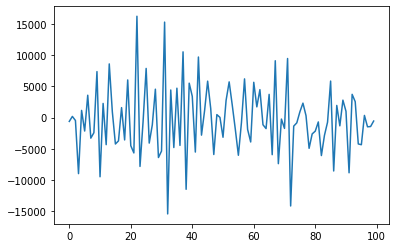

In [98]:
import matplotlib.pyplot as plt
plt.plot(actual_predictions)
actual_predictions.shape

In [99]:
actual_predictions.shape

(100,)

Index(['22-01-2020', '23-01-2020', '24-01-2020', '25-01-2020', '26-01-2020',
       '27-01-2020', '28-01-2020', '29-01-2020', '30-01-2020', '31-01-2020',
       ...
       '18-07-2020', '19-07-2020', '20-07-2020', '21-07-2020', '22-07-2020',
       '23-07-2020', '24-07-2020', '25-07-2020', '26-07-2020', '27-07-2020'],
      dtype='object', name='Date', length=188)
DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21',
               '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
               '2020-07-26', '2020-07-27'],
              dtype='datetime64[ns]', length=188, freq='D')
(188, 1)
51360.87956040403


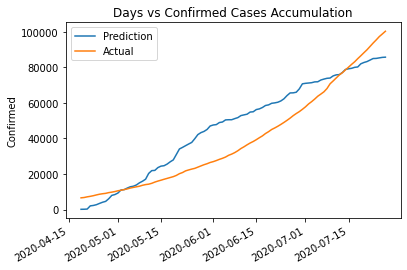

In [100]:
#visualization   
fig, ax = plt.subplots() 
plt.title('Days vs Confirmed Cases Accumulation')
plt.ylabel('Confirmed')

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

print (date.index)
date_list=pd.date_range(start=date.index[0],end=date.index[-1])
print (date_list)

#plt.axvline(x=np.array(date_list)[66], color='r', linestyle='--')

#ax.text(0.2*(left+right), 0.8*(bottom+top), 'input sequence',
   #     horizontalalignment='left',
    #    verticalalignment='center',
     #   fontsize=10, color='red',
      #  transform=ax.transAxes)
#ax.text(0.0125*(left+right), 0.77*(bottom+top), '______________________',
 #       horizontalalignment='left',
  #      verticalalignment='center',
   #     fontsize=20, color='red',
    #    transform=ax.transAxes)
 





sumpred=np.cumsum(np.absolute(actual_predictions))

print (date.values.shape) 
print (sqrt(mean_squared_error(date.Confirmed[:100],sumpred)))

plt.plot(np.array(date_list)[88:188],sumpred,label='Prediction')
plt.plot(np.array(date_list)[88:188],date.Confirmed[88:188],label='Actual')
plt.xticks(rotation=90)
fig.autofmt_xdate()
plt.legend(loc=2)
plt.show()